In [60]:
from __future__ import print_function
import IPython
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import load_model, Model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, LSTM, Reshape, Lambda, RepeatVector
from keras.initializers import glorot_uniform
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras import backend as K

%matplotlib inline

# 1. Data base
Our data set is from [Tushare](https://tushare.org/), Tushare is a free, open source python financial data interface package. It mainly realizes the process of data collection, cleaning and data storage for stocks and other financial data. It can provide financial analysts with fast, neat, and diverse data that is easy to analyze, greatly reducing the workload for them in terms of data acquisition. They are more focused on the research and implementation of strategies and models.

To test the basic fonction of our alogrithm, we have choose [Wuhan Iron and Steel Co Ltd (SHSE:600005) ](https://www.investing.com/equities/wuhan-steel) for test. Wuhan Iron and Steel (Group) Corporation (WISCO), is a Chinese state-owned enterprise. It started to operate in 1958 in Qingshan, Wuhan, Hubei, China. And you can get more information of this company from this [site](https://en.wikipedia.org/wiki/Wuhan_Iron_and_Steel_Corporation).



## 1.0 Tushare


In [3]:
import tushare as ts
import os

600782 新钢
600019 宝钢
000898 鞍钢
000932 华菱
601005 重庆
601003 柳钢


In [7]:
filename = 'E:/python/data_/data_original.csv'
#for code in ['600005', '600782', '000898','000932', '601005', '601003']:
for code in ['600005']:
    if os.path.exists(filename):
        df.to_csv(filename, mode='a', header=None)
    else:
        df.to_csv(filename)

In [5]:
model_data = pd.read_csv('data_/data_original.csv')
# reverse the data frame
model_data = model_data.sort_values(by='date')
# print some example data
model_data.head()

,date,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20,turnover
568,2015-03-16,4.00,4.07,4.03,3.99,139156.17,0.04,1.00,4.030,4.030,4.030,139156.17,139156.17,139156.17,0.54
567,2015-03-17,4.04,4.17,4.12,4.04,235925.98,0.09,2.23,4.075,4.075,4.075,187541.08,187541.08,187541.08,0.92
566,2015-03-18,4.12,4.43,4.33,4.11,413357.44,0.21,5.10,4.160,4.160,4.160,262813.20,262813.20,262813.20,1.61
565,2015-03-19,4.34,4.34,4.25,4.20,309555.75,-0.08,-1.85,4.183,4.183,4.183,274498.83,274498.83,274498.83,1.21
564,2015-03-20,4.25,4.29,4.27,4.21,184508.08,0.02,0.47,4.200,4.200,4.200,256500.68,256500.68,256500.68,0.72


## 1.1 data set
The data are mostly [pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html) type. For a share, it gathers the information of : "data", "open price", "close price", "highest price", "lowest price", "total volume", "the change of price", "rate of the change of price", "5-day average price", "10-day average price", "20-day average price", "5-day average volume", "10-day average volume", "20-day average volume", "turn over rate". (As the [document](http://tushare.org/trading.html#id2) shown)

In [9]:
# we don't need the date columns 
split_date = '2017-06-01'
training_set, test_set = model_data[model_data['date']<split_date], model_data[model_data['date']>=split_date]
training_set = training_set.drop('date', 1)
test_set = test_set.drop('date', 1)
print('the size of trainging set is :',training_set.shape)
print('the size of test set is :', test_set.shape)

the size of trainging set is : (441, 14)
the size of test set is : (128, 14)


### 1.1.1 normalization

As we can see from the upper data example, the values of the data varience varies a lot, especially for the volumes. So we have to normalise these data to avoid the situation that these facters may have a unnormal effect to our model.


$$v_i = v_i / v_0 - 1$$

In [15]:
window_len = 10
# choose the columns that we want to normalise
norm_cols = ['volume','v_ma5','v_ma10','v_ma20']
norm_factor = {}

In [23]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        norm_factor[col] = temp_set[col].iloc[0].copy()
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['close'][window_len:].values/training_set['close'][:-window_len].values)-1
print(norm_factor)

{'v_ma5': 998597.15, 'volume': 720866.31, 'v_ma10': 853193.71, 'v_ma20': 496239.27}


In [24]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/norm_factor[col] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['close'][window_len:].values/test_set['close'][:-window_len].values)-1

In [25]:
LSTM_training_inputs[0]

,open,high,close,low,volume,price_change,p_change,ma5,ma10,ma20,v_ma5,v_ma10,v_ma20,turnover
568,4.00,4.07,4.03,3.99,0.000000,0.04,1.00,4.030,4.030,4.030,0.000000,0.000000,0.000000,0.54
567,4.04,4.17,4.12,4.04,0.695404,0.09,2.23,4.075,4.075,4.075,0.347702,0.347702,0.347702,0.92
566,4.12,4.43,4.33,4.11,1.970457,0.21,5.10,4.160,4.160,4.160,0.888621,0.888621,0.888621,1.61
565,4.34,4.34,4.25,4.20,1.224520,-0.08,-1.85,4.183,4.183,4.183,0.972595,0.972595,0.972595,1.21
564,4.25,4.29,4.27,4.21,0.325907,0.02,0.47,4.200,4.200,4.200,0.843258,0.843258,0.843258,0.72
563,4.33,4.51,4.40,4.32,1.459798,0.13,3.04,4.274,4.233,4.233,1.135217,0.946014,0.946014,1.34
562,4.41,4.80,4.71,4.36,3.421351,0.31,7.04,4.392,4.301,4.301,1.680407,1.299634,1.299634,2.40
561,4.64,4.68,4.54,4.50,0.966094,-0.17,-3.61,4.434,4.331,4.331,1.479534,1.257941,1.257941,1.07
560,4.50,4.60,4.44,4.39,0.446342,-0.10,-2.20,4.472,4.343,4.343,1.323898,1.167764,1.167764,0.79
559,4.45,4.58,4.49,4.36,0.488811,0.05,1.13,4.516,4.358,4.358,1.356479,1.099868,1.099868,0.81


In [ ]:
import utils

In [8]:
#n_a is the number of hidden states for LSTM 
n_a = 64 
n_values = 15
reshapor = Reshape((1, 15))                        
LSTM_cell = LSTM(n_a, return_state = True)         
densor = Dense(n_values, activation='softmax')    

In [9]:
# GRADED FUNCTION: imple_model

def imple_model(Tx, n_a, n_values):
    # Implement the model   
    # Define the input of your model with a shape 
    X = Input(shape=(Tx, n_values))
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    outputs = []
    for t in range(Tx):
        x = Lambda(lambda x: X[:,t,:])(X)
        x = reshapor(x)
        a, _, c = LSTM_cell(x, initial_state=[a, c])
        out = densor(a)
        outputs.append(out)
        
    model = Model(inputs=[X, a0, c0], outputs=outputs)
    
    return model

# 2. LSTM (Long short-term memory)
Long short-term memory (LSTM) units (or blocks) are a building unit for layers of a recurrent neural network (RNN). A RNN composed of LSTM units is often called an LSTM network. A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate.

##  2.1 

<img src="images/LSTM.png" style="width:400;height:300px;">

In [26]:
# transform the data into array of numpy, which is easier to trait.
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)
print('the size of trainging set is :',LSTM_training_inputs.shape)
print('the size of test set is :', LSTM_test_inputs.shape)

the size of trainging set is : (431, 10, 14)
the size of test set is : (118, 10, 14)


In [28]:
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

So, the `build_model` functions constructs an empty model unimaginatively called model (`model = Sequential`), to which an LSTM layer is added. That layer has been shaped to fit our inputs. The function also includes more generic neural network features, like [dropout](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/) and [activation functions](https://dashee87.github.io/data%20science/deep%20learning/visualising-activation-functions-in-neural-networks/). Now, we just need to specify the number of neurons to place in the LSTM layer, as well as the data on which the model will be trained.

In [29]:
# random seed 
np.random.seed(202)
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = (training_set['close'][window_len:].values/training_set['close'][:-window_len].values)-1
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 3s - loss: 0.2526
Epoch 2/50
 - 2s - loss: 0.1109
Epoch 3/50
 - 2s - loss: 0.0766
Epoch 4/50
 - 2s - loss: 0.0674
Epoch 5/50
 - 2s - loss: 0.0589
Epoch 6/50
 - 2s - loss: 0.0587
Epoch 7/50
 - 2s - loss: 0.0548
Epoch 8/50
 - 2s - loss: 0.0520
Epoch 9/50
 - 2s - loss: 0.0509
Epoch 10/50
 - 2s - loss: 0.0540
Epoch 11/50
 - 2s - loss: 0.0488
Epoch 12/50
 - 2s - loss: 0.0487
Epoch 13/50
 - 2s - loss: 0.0517
Epoch 14/50
 - 2s - loss: 0.0493
Epoch 15/50
 - 2s - loss: 0.0524
Epoch 16/50
 - 2s - loss: 0.0477
Epoch 17/50
 - 2s - loss: 0.0461
Epoch 18/50
 - 2s - loss: 0.0482
Epoch 19/50
 - 2s - loss: 0.0465
Epoch 20/50
 - 2s - loss: 0.0487
Epoch 21/50
 - 2s - loss: 0.0462
Epoch 22/50
 - 2s - loss: 0.0447
Epoch 23/50
 - 2s - loss: 0.0466
Epoch 24/50
 - 2s - loss: 0.0450
Epoch 25/50
 - 2s - loss: 0.0450
Epoch 26/50
 - 2s - loss: 0.0422
Epoch 27/50
 - 2s - loss: 0.0448
Epoch 28/50
 - 2s - loss: 0.0465
Epoch 29/50
 - 2s - loss: 0.0443
Epoch 30/50
 - 2s - loss: 0.0458
Epoch 31/50
 - 2s -

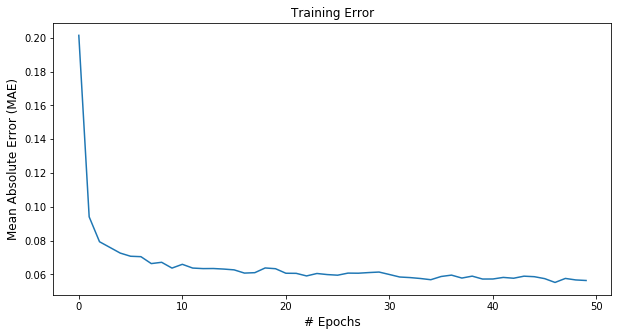

In [66]:
fig, ax1 = plt.subplots(1,1,figsize=(10,5))

ax1.plot(eth_history.epoch, eth_history.history['loss'])
ax1.set_title('Training Error')

if eth_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

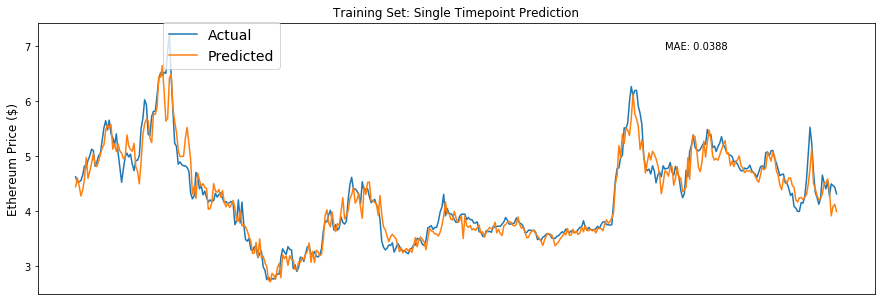

In [70]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import datetime

fig, ax1 = plt.subplots(1,1,figsize=(15,5))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])
ax1.plot(model_data[model_data['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         training_set['close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_training_inputs))+1)-\
            (training_set['close'].values[window_len:])/(training_set['close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
plt.show()

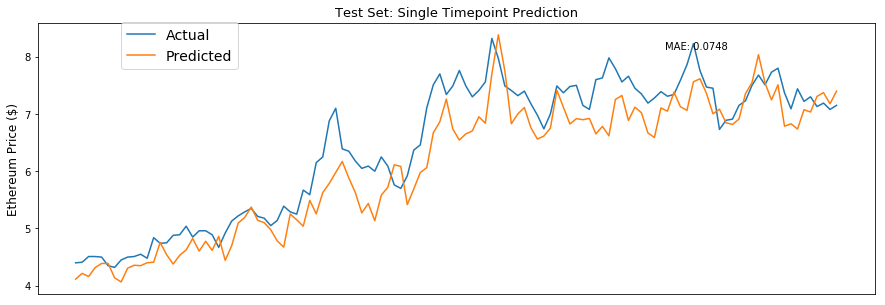

In [71]:
fig, ax1 = plt.subplots(1,1,figsize=(15,5))
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         test_set['close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_test_inputs))+1) * test_set['close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_test_inputs))+1)-\
            (test_set['close'].values[window_len:])/(test_set['close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

predict the prices for next 5 days

In [41]:
# random seed 
np.random.seed(202)
# predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 5
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['close'])-pred_range):
    LSTM_training_outputs.append((training_set['close'][i:i+pred_range].values/
                                  training_set['close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 2s - loss: 0.2015
Epoch 2/50
 - 2s - loss: 0.0941
Epoch 3/50
 - 2s - loss: 0.0793
Epoch 4/50
 - 2s - loss: 0.0760
Epoch 5/50
 - 2s - loss: 0.0726
Epoch 6/50
 - 2s - loss: 0.0708
Epoch 7/50
 - 2s - loss: 0.0705
Epoch 8/50
 - 2s - loss: 0.0664
Epoch 9/50
 - 2s - loss: 0.0672
Epoch 10/50
 - 2s - loss: 0.0637
Epoch 11/50
 - 2s - loss: 0.0660
Epoch 12/50
 - 2s - loss: 0.0638
Epoch 13/50
 - 2s - loss: 0.0634
Epoch 14/50
 - 2s - loss: 0.0635
Epoch 15/50
 - 2s - loss: 0.0632
Epoch 16/50
 - 2s - loss: 0.0627
Epoch 17/50
 - 2s - loss: 0.0608
Epoch 18/50
 - 2s - loss: 0.0610
Epoch 19/50
 - 2s - loss: 0.0638
Epoch 20/50
 - 2s - loss: 0.0634
Epoch 21/50
 - 2s - loss: 0.0607
Epoch 22/50
 - 2s - loss: 0.0606
Epoch 23/50
 - 2s - loss: 0.0591
Epoch 24/50
 - 2s - loss: 0.0605
Epoch 25/50
 - 2s - loss: 0.0599
Epoch 26/50
 - 2s - loss: 0.0595
Epoch 27/50
 - 2s - loss: 0.0608
Epoch 28/50
 - 2s - loss: 0.0607
Epoch 29/50
 - 2s - loss: 0.0611
Epoch 30/50
 - 2s - loss: 0.0614
Epoch 31/50
 - 2s -

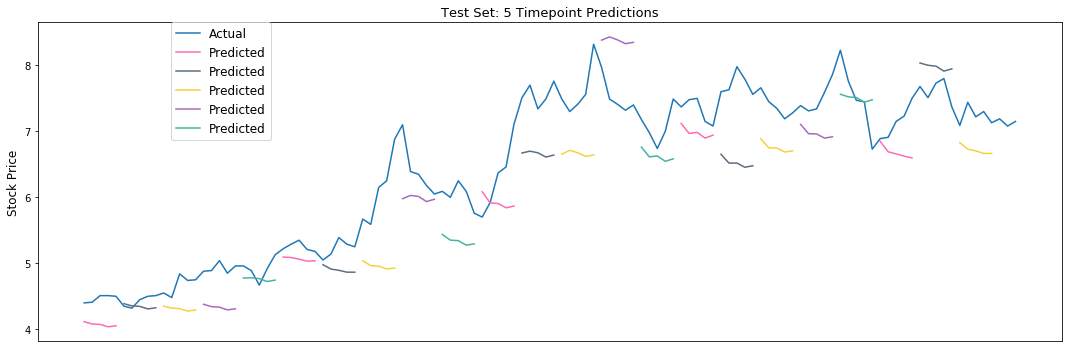

In [72]:
# little bit of reformatting the predictions to closing prices
pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))
pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D"]
fig, ax1 = plt.subplots(1,1,figsize=(15,5))
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.plot(model_data[model_data['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         test_set['close'][window_len:], label='Actual')
for i, (bt_pred) in enumerate(zip(pred_prices)):
    # Only adding lines to the legend once
    if i<5:
        ax1.plot(model_data[model_data['date']>= split_date]['date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 bt_pred[0], color=pred_colors[i%5], label="Predicted")
    else: 
        ax1.plot(model_data[model_data['date']>= split_date]['date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 bt_pred[0], color=pred_colors[i%5])

ax1.set_title('Test Set: 5 Timepoint Predictions',fontsize=13)
ax1.set_ylabel('Stock Price',fontsize=12)
ax1.set_xticklabels('')
ax1.legend(bbox_to_anchor=(0.13, 1), loc=2, borderaxespad=0., prop={'size': 12})
fig.tight_layout()
plt.show()